In [1]:
from langgraph.graph import StateGraph, START, END

from langgraph.checkpoint.redis import RedisSaver
from states import *
from prompts import *
import dotenv
dotenv.load_dotenv()

from parsers import parse_directory_files

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from states import State, DocMetadata, Tasks, DocumentWithMetadata, DocumentToTaskMapper, ExecutionAgent
from prompts import METADATA_EXTRACTOR_PROMPT, TASK_PARSER_PROMPT, DOCUMENT_TO_TASK_MAPPER_PROMPT
from parsers import parse_directory_files
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI


In [2]:
# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(model="o4-mini", reasoning_effort="high")
# # state = State(data_path="/Users/omar/work/andrea/data")

# files = parse_directory_files("/Users/omar/work/andrea/data_temp")




In [3]:
# files = parse_directory_files("/Users/omar/work/andrea/data")

# for file in files:
#     print(file['file_name'])
#     print(file['content'])
#     print("--------------------------------")

In [4]:
import pickle

# # write pickle

# with open('files.pkl', 'wb') as f:
#     pickle.dump(files, f)

with open('files.pkl', 'rb') as f:
    files = pickle.load(f)
files

[{'file_name': 'employee_payroll.png',
  'content': "ACME Inc.\n\nPayroll Register\n\nDisplay Retro Results: No\nHide Zero Gross and Zero Net Results: No\nPeriod: 7/20/2024 - 08/02/2024 (Non-Exempt BI-Weekly (WDPAY))\nPay Run Groups and/or Pay Group Details: Non-Exempt Hourly - Regular\n\nRow 1:\nGroup Name: US Hourly CA (2nd Check) (Pay Group Detail)\nPayroll Result: 7/20/2024 - 8/2/2024 (Non-Exempt BI-Weekly (WDPAY1)) (Period)\nWorker: \nGross Pay: 0\nAdd to Gross - PCG - Class Report Field: 0\nFederal Taxable Don't W/H - PCG - Class Report Field: 0\nFederal Taxable W/H - PCG - Class Report Field: 0\nNet Pay: 0\nResult Type - Description: 0\nStatus: 0\n\nRow 2:\nEmp 1: 08/02/2024 (Regular) In Progress\nGross Pay: $1,191.42\nAdd to Gross - PCG - Class Report Field: $1,191.42\nFederal Taxable Don't W/H - PCG - Class Report Field: $0.00\nFederal Taxable W/H - PCG - Class Report Field: $1,191.42\nNet Pay: $984.42\nResult Type - Description: On Demand Payment - Replacement\nStatus: Comple

In [ ]:
# model = ChatOpenAI(model="gpt-4.1-mini", ) #o4-mini #reasoning_effort="high"
model = ChatOpenAI(model="o4-mini", reasoning_effort="high")
# model = ChatOpenAI(model="gpt-4.1")

def metadata_extractor(state: State):
    print("--------------------------------")
    print("Extracting metadata")
    # files = parse_directory_files(state['data_path'])

    for file in files:

        messages = [
            SystemMessage(content=METADATA_EXTRACTOR_PROMPT),
            HumanMessage(content="File Name: " + file['file_name'] + "\nFile Content: \n" + file['content'])
        ]


        response = model.with_structured_output(DocMetadata).invoke(messages)
        state.docs_content_with_metadata.append(DocumentWithMetadata(name=response.name, purpose=response.purpose, possible_use_cases=response.possible_use_cases, content=file['content']))
        print(file['file_name'], "\n", response)
    return state


def tasks_parser(state: State):
    print("--------------------------------")
    print("Parsing tasks")
    tasks = state.tasks_raw

    messages = [
        SystemMessage(content=TASK_PARSER_PROMPT),
        HumanMessage(content=tasks)
    ]

    response = model.with_structured_output(Tasks).invoke(messages)
    state.tasks_parsed = response
    print(response)
    print("length of tasks: ", len(response.tasks))
    return state
    

def document_to_task_mapper(state: State):
    print("--------------------------------")
    print("Mapping documents to tasks")
    print(state.tasks_parsed.tasks)


    for task in state.tasks_parsed.tasks:
        for doc in state.docs_content_with_metadata:
            organized_docs = ""
            for doc in state.docs_content_with_metadata: 
                organized_docs += "\n\nFile Name: " + doc.name + "\nFile Purpose: " + doc.purpose + "\nFile Possible Use Cases: " + doc.possible_use_cases + "\nFile Content: \n<document_content " + doc.name + ">\n" + doc.content + "\n</document_content " + doc.name + ">\n\n"

        messages = [
            SystemMessage(content=DOCUMENT_TO_TASK_MAPPER_PROMPT),
            HumanMessage(content="Task: " + task + "\nDocuments: " + str(state.docs_content_with_metadata))
        ]

        response = model.with_structured_output(DocumentToTaskMapper).invoke(messages)
        state.document_to_task_mapper.append(response)
        print(task, "\n", response)


    return state


def execution_agent(state: State):
    print("--------------------------------")
    print("Executing tasks")
    print(state.document_to_task_mapper)
    
    for item in state.document_to_task_mapper:
        docs_content = ""
        for doc in item.docs:
            docs_content += "\n\nFile Name: " + doc.name + "\nFile Content: \n<document_content " + doc.name + ">\n" + doc.content + "\n</document_content " + doc.name + ">\n\n"

        messages = [
            SystemMessage(content=EXECUTION_AGENT_PROMPT),
            HumanMessage(content="Task: " + str(item.task) + "\nDocuments: \n" + docs_content)
        ]

        response = model.with_structured_output(ExecutionAgent).invoke(messages)
        state.execution_task_output.append(response)
        print(item.task, "\n", response)
    
    return state

def reflector(state: State):
    print("--------------------------------")
    print("Reflecting on the tasks")
    state.is_in_reflection = True

    messages = [
        SystemMessage(content=REFLECTOR_PROMPT),
        HumanMessage(content=str(state.execution_task_output))
    ]

    response = model.invoke(messages)
    print(response)
    
    return state

def reporter(state: State):
    print("--------------------------------")
    print("Reporting results")
    print(state.execution_task_output)

    messages = [
        SystemMessage(content=REPORTER_PROMPT),
        HumanMessage(content=str(state.execution_task_output))
    ]

    state.reporter = model.with_structured_output(Reporter).invoke(messages).output
    print("**************************************************")
    print(state.reporter)
    print("**************************************************")


    return state

def should_continue(state: State):
    state.is_in_reflection = True
    state.task_current_iteration +=1
    if state.task_current_iteration < state.task_max_iterations:
        return 'continue'
    else:
        return 'stop'
    return state

19:16:46 langgraph.checkpoint.redis INFO   Redis client is a standalone client
19:16:46 redisvl.index.index INFO   Index already exists, not overwriting.
19:16:46 redisvl.index.index INFO   Index already exists, not overwriting.
19:16:46 redisvl.index.index INFO   Index already exists, not overwriting.


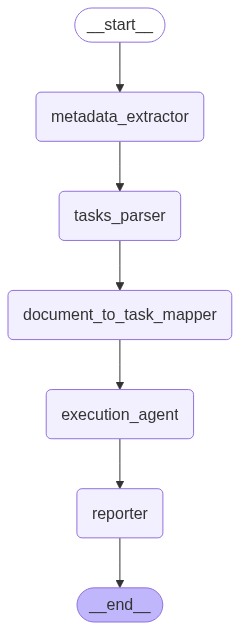

In [ ]:


builder = StateGraph(State)
builder.add_node("metadata_extractor", metadata_extractor)
builder.add_node("tasks_parser", tasks_parser)
builder.add_node("document_to_task_mapper", document_to_task_mapper)
builder.add_node("execution_agent", execution_agent)
# builder.add_node("reflector", reflector)
builder.add_node("reporter", reporter)

builder.add_edge(START, "metadata_extractor")
builder.add_edge("metadata_extractor", "tasks_parser")
builder.add_edge("tasks_parser", "document_to_task_mapper")
builder.add_edge("document_to_task_mapper", "execution_agent")
builder.add_edge("execution_agent", "reporter")
builder.add_edge("reporter", END)

# builder.add_edge("execution_agent", "reflector")

# builder.add_conditional_edges("reflector",should_continue, {"stop": "reporter",
#     "continue": "execution_agent"})

# # builder.add_edge("reflector", "reporter")
# builder.add_edge("reporter", END)

REDIS_URI = "redis://localhost:6379/0"
with RedisSaver.from_conn_string(REDIS_URI) as checkpointer:
    checkpointer.setup()
    
    graph = builder.compile(checkpointer=checkpointer)

graph


In [7]:
tasks = """TASKS:

1. Compare ADP payroll data, bank payroll data, and settlement runs payroll data. Make sure that the numeric totals are all the same


2. Compare employee payroll data from screenshots to the employee payroll data from the CSV. Make sure that the payroll amounts in the CSV match the payroll amounts in the screenshot. 


3. Compare employee total payroll data from screenshots to the total employee payroll from the CSV. Make sure the 2 payroll amounts match. 
"""

In [8]:
graph.invoke(input={"data_path": "/Users/omar/work/andrea/data", "tasks_raw": tasks}, config={"configurable": {"thread_id": "1"}})

--------------------------------
Extracting metadata
19:16:52 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
employee_payroll.png 
 name='ACME Inc. Payroll Register' purpose='To provide a detailed payroll register for ACME Inc. covering the pay period 7/20/2024 – 08/02/2024 for Non-Exempt Hourly employees, showing gross pay, taxable wages, net pay, result types, and status for each worker.' possible_use_cases='Payroll processing and reconciliation; financial accounting and reporting; audit and compliance reviews; employee pay verification; tax reporting; HR record-keeping.'
19:16:56 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Payroll reconcilation DEMO.csv 
 name='Payroll reconcilation DEMO.csv' purpose='To reconcile payroll settlement run totals against payroll register amounts for a given payroll cycle, including identifying variances and providing approval records.' possible_use_cases='Aud

{'data_path': '/Users/omar/work/andrea/data',
 'tasks_raw': 'TASKS:\n\n1. Compare ADP payroll data, bank payroll data, and settlement runs payroll data. Make sure that the numeric totals are all the same\n\n\n2. Compare employee payroll data from screenshots to the employee payroll data from the CSV. Make sure that the payroll amounts in the CSV match the payroll amounts in the screenshot. \n\n\n3. Compare employee total payroll data from screenshots to the total employee payroll from the CSV. Make sure the 2 payroll amounts match. \n',
 'docs_content_with_metadata': [DocumentWithMetadata(name='ACME Inc. Payroll Register', purpose='To provide a detailed payroll register for ACME Inc. covering the pay period 7/20/2024 – 08/02/2024 for Non-Exempt Hourly employees, showing gross pay, taxable wages, net pay, result types, and status for each worker.', possible_use_cases='Payroll processing and reconciliation; financial accounting and reporting; audit and compliance reviews; employee pay ve

In [9]:
state = graph.get_state(config={"configurable": {"thread_id": "1"}}).values

In [12]:
state.keys()

dict_keys(['data_path', 'tasks_raw', 'docs_content_with_metadata', 'tasks_parsed', 'document_to_task_mapper', 'execution_task_output', 'reflector', 'reporter', 'task_max_iterations'])